# **Cricket Match Winner Prediction Model**

# **Importing the required libraries**

In [274]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# **Loading the datasets**

In [275]:

# Load the datasets
match = pd.read_csv('matches.csv')
delivery = pd.read_csv('deliveries.csv')

In [276]:
match.head()

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,IPL-2017,Rajkot,07-04-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN
3,4,IPL-2017,Indore,08-04-2017,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN


In [277]:
match.shape

(756, 18)

In [278]:
delivery.head()

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NaN,NaN,NaN


# **Data Preperation**

In [279]:
# Grouping delivery data by match_id and inning to calculate total runs
total_score_df = delivery.groupby(['match_id','inning']).sum()['total_runs'].reset_index()

In [280]:
total_score_df = total_score_df[total_score_df['inning'] == 1]

In [281]:
total_score_df

,match_id,inning,total_runs
0,1,1,207
2,2,1,184
4,3,1,183
6,4,1,163
8,5,1,157
...,...,...,...
1518,11347,1,143
1520,11412,1,136
1522,11413,1,171
1524,11414,1,155


In [282]:
match_df = match.merge(total_score_df[['match_id','total_runs']], left_on='id', right_on='match_id')

In [283]:
match_df

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,match_id,total_runs
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,207
1,2,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN,2,184
2,3,IPL-2017,Rajkot,07-04-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN,3,183
3,4,IPL-2017,Indore,08-04-2017,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN,4,163
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN,5,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,11347,IPL-2019,Mumbai,05-05-2019,Kolkata Knight Riders,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,9,HH Pandya,Wankhede Stadium,Nanda Kishore,O Nandan,S Ravi,11347,143
752,11412,IPL-2019,Chennai,07-05-2019,Chennai Super Kings,Mumbai Indians,Chennai Super Kings,bat,normal,0,Mumbai Indians,0,6,AS Yadav,M. A. Chidambaram Stadium,Nigel Llong,Nitin Menon,Ian Gould,11412,136
753,11413,IPL-2019,Visakhapatnam,08-05-2019,Sunrisers Hyderabad,Delhi Capitals,Delhi Capitals,field,normal,0,Delhi Capitals,0,2,RR Pant,ACA-VDCA Stadium,NaN,NaN,NaN,11413,171
754,11414,IPL-2019,Visakhapatnam,10-05-2019,Delhi Capitals,Chennai Super Kings,Chennai Super Kings,field,normal,0,Chennai Super Kings,0,6,F du Plessis,ACA-VDCA Stadium,Sundaram Ravi,Bruce Oxenford,Chettithody Shamshuddin,11414,155


In [284]:
match_df['team1'].unique()

array(['Sunrisers Hyderabad', 'Mumbai Indians', 'Gujarat Lions',
       'Rising Pune Supergiant', 'Royal Challengers Bangalore',
       'Kolkata Knight Riders', 'Delhi Daredevils', 'Kings XI Punjab',
       'Chennai Super Kings', 'Rajasthan Royals', 'Deccan Chargers',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Rising Pune Supergiants',
       'Delhi Capitals'], dtype=object)

In [285]:
teams = [
    'Sunrisers Hyderabad',
    'Mumbai Indians',
    'Royal Challengers Bangalore',
    'Kolkata Knight Riders',
    'Kings XI Punjab',
    'Chennai Super Kings',
    'Rajasthan Royals',
    'Delhi Capitals'
]


In [286]:
# Update team names
match_df['team1'] = match_df['team1'].str.replace('Delhi Daredevils', 'Delhi Capitals')
match_df['team2'] = match_df['team2'].str.replace('Delhi Daredevils', 'Delhi Capitals')
match_df['team1'] = match_df['team1'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad')
match_df['team2'] = match_df['team2'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad')

# Filter for matches where teams are from the list
match_df = match_df[match_df['team1'].isin(teams)]
match_df = match_df[match_df['team2'].isin(teams)]

# Remove matches where DLS was applied
match_df = match_df[match_df['dl_applied'] == 0]

# Select relevant columns
match_df = match_df[['match_id','city','winner','total_runs']]


In [287]:
match_df.shape

(626, 4)

In [288]:

# Merge with deliveries data
delivery_df = match_df.merge(delivery, on='match_id')

# Filter for second innings
delivery_df = delivery_df[delivery_df['inning'] == 2]

In [289]:
delivery_df

,match_id,city,winner,total_runs_x,inning,batting_team,bowling_team,over,ball,batsman,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs_y,player_dismissed,dismissal_kind,fielder
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,0,0,0,0,1,0,1,NaN,NaN,NaN
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,0,0,0,NaN,NaN,NaN
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,0,0,0,NaN,NaN,NaN
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,0,0,0,0,2,0,2,NaN,NaN,NaN
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,0,0,0,0,4,0,4,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149573,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,2,RA Jadeja,...,0,0,0,0,1,0,1,NaN,NaN,NaN
149574,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,3,SR Watson,...,0,0,0,0,2,0,2,NaN,NaN,NaN
149575,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,4,SR Watson,...,0,0,0,0,1,0,1,SR Watson,run out,KH Pandya
149576,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,5,SN Thakur,...,0,0,0,0,2,0,2,NaN,NaN,NaN


In [290]:
# Convert 'total_runs_y' to numeric before applying cumsum
delivery_df['total_runs_y'] = pd.to_numeric(delivery_df['total_runs_y'], errors='coerce')

In [291]:
delivery_df['current_score'] = delivery_df.groupby('match_id')['total_runs_y'].cumsum()
delivery_df['runs_left'] = delivery_df['total_runs_x'] - delivery_df['current_score']
delivery_df['balls_left'] = 126 - (delivery_df['over'] * 6 + delivery_df['ball'])

delivery_df['player_dismissed'] = delivery_df['player_dismissed'].fillna("0")
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].apply(lambda x: x if x == "0" else "1")
delivery_df['player_dismissed'] = pd.to_numeric(delivery_df['player_dismissed'], errors='coerce')

In [292]:
delivery_df.shape

(72413, 27)

In [293]:
wickets = delivery_df.groupby('match_id')['player_dismissed'].cumsum().values
delivery_df['wickets'] = 10 - wickets

delivery_df['crr'] = (delivery_df['current_score'] * 6) / (120 - delivery_df['balls_left'])
delivery_df['rrr'] = (delivery_df['runs_left'] * 6) / delivery_df['balls_left']

In [294]:
def result(row):
    return 1 if row['batting_team'] == row['winner'] else 0

delivery_df['result'] = delivery_df.apply(result, axis=1)

In [295]:
final_df = delivery_df[['batting_team','bowling_team','city','runs_left','balls_left','wickets','total_runs_x','crr','rrr','result','winner']]

final_df = final_df.sample(final_df.shape[0])
final_df.dropna(inplace=True)
final_df = final_df[final_df['balls_left'] != 0]

In [296]:
final_df.isnull().sum()

batting_team    0
bowling_team    0
city            0
runs_left       0
balls_left      0
wickets         0
total_runs_x    0
crr             0
rrr             0
result          0
winner          0
dtype: int64

# **Data Visualisation**

<Axes: >

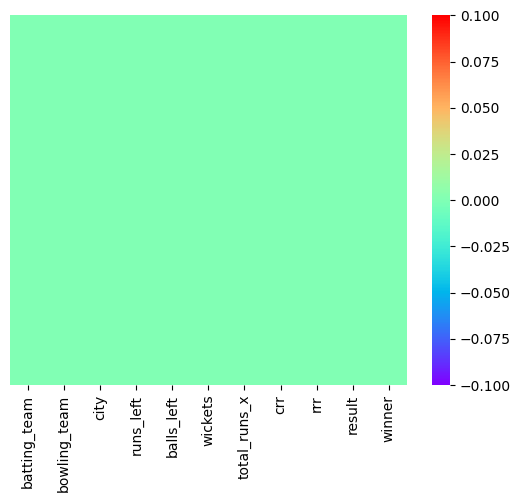

In [297]:
sns.heatmap(final_df.isnull(),cmap='rainbow',yticklabels=False)

**this means there are no null data in finaldf**

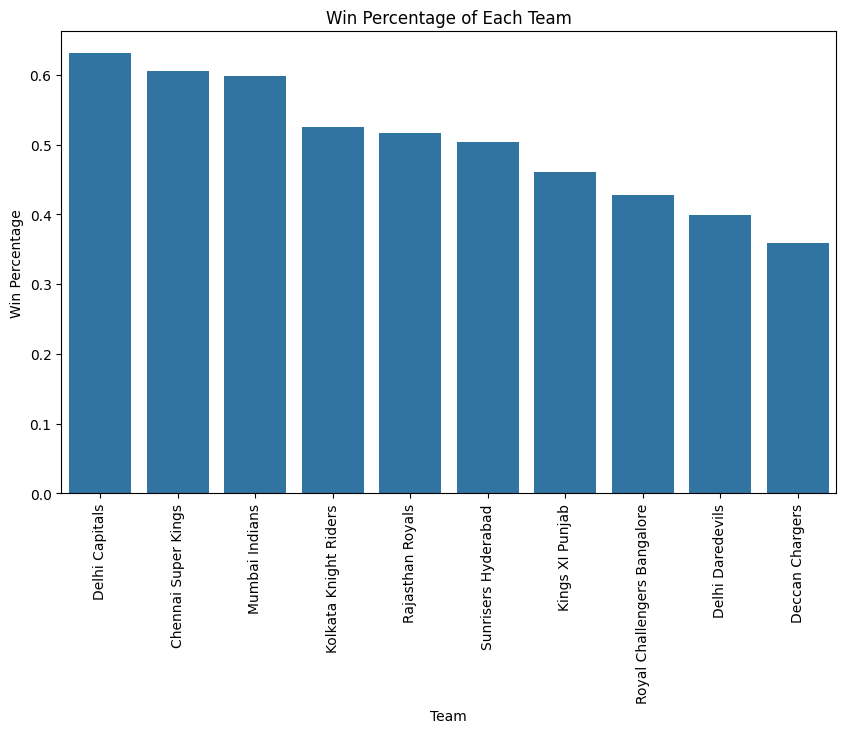

In [298]:

team_wins = final_df['winner'].value_counts()
team_matches = final_df['batting_team'].value_counts() + final_df['bowling_team'].value_counts()
win_percentage = (team_wins / team_matches).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=win_percentage.index, y=win_percentage.values)
plt.xticks(rotation=90)
plt.xlabel('Team')
plt.ylabel('Win Percentage')
plt.title('Win Percentage of Each Team')
plt.show()

In [299]:
delivery_df['city'].unique()

array(['Hyderabad', 'Bangalore', 'Mumbai', 'Indore', 'Kolkata', 'Delhi',
       'Chandigarh', 'Jaipur', 'Chennai', 'Cape Town', 'Port Elizabeth',
       'Durban', 'Centurion', 'East London', 'Johannesburg', 'Kimberley',
       'Bloemfontein', 'Ahmedabad', 'Cuttack', 'Nagpur', 'Dharamsala',
       'Visakhapatnam', 'Pune', 'Raipur', 'Ranchi', 'Abu Dhabi',
       'Sharjah', nan, 'Mohali', 'Bengaluru'], dtype=object)

In [300]:
teams

['Sunrisers Hyderabad',
 'Mumbai Indians',
 'Royal Challengers Bangalore',
 'Kolkata Knight Riders',
 'Kings XI Punjab',
 'Chennai Super Kings',
 'Rajasthan Royals',
 'Delhi Capitals']

# **Splitting the data**

In [301]:
# Defining the features (X) and target (y)
X = final_df.iloc[:,:-1]
y = final_df.iloc[:,-1]

In [302]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)


In [303]:
X_train

,batting_team,bowling_team,city,runs_left,balls_left,wickets,total_runs_x,crr,rrr,result
141702,Rajasthan Royals,Mumbai Indians,Mumbai,183,109,10,191,4.363636,10.073394,1
35881,Chennai Super Kings,Delhi Daredevils,Delhi,129,84,9,185,9.333333,9.214286,1
69281,Chennai Super Kings,Kolkata Knight Riders,Kolkata,118,92,10,158,8.571429,7.695652,1
147170,Delhi Capitals,Chennai Super Kings,Chennai,97,37,2,186,6.433735,15.729730,0
134721,Rajasthan Royals,Kolkata Knight Riders,Kolkata,75,42,9,179,8.000000,10.714286,0
...,...,...,...,...,...,...,...,...,...,...
108422,Chennai Super Kings,Sunrisers Hyderabad,Hyderabad,128,78,8,192,9.142857,9.846154,0
137631,Delhi Capitals,Kolkata Knight Riders,Delhi,83,51,9,193,9.565217,9.764706,1
131356,Kings XI Punjab,Kolkata Knight Riders,Indore,187,80,8,250,9.450000,14.025000,0
64913,Royal Challengers Bangalore,Kolkata Knight Riders,Kolkata,188,114,9,190,2.000000,9.894737,0


In [304]:
trf = ColumnTransformer([
    ('trf', OneHotEncoder(drop='first'), ['batting_team', 'bowling_team', 'city'])
], remainder='passthrough')

In [305]:
pipe = Pipeline(steps=[
    ('step1', trf),
    ('step2', LogisticRegression(solver='liblinear'))
])

In [306]:
pipe.fit(X_train, y_train)

c:\Users\visha\OneDrive\Desktop\NxtCatch\environment\Lib\site-packages\sklearn\compose\_column_transformer.py:1651: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first'),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('step2', LogisticRegression(solver='liblinear'))])

In [307]:
y_pred = pipe.predict(X_test)

In [308]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8022856341583117


In [309]:
pickle.dump(pipe, open('model.pkl', 'wb'))